# NADA for Classification

This notebook aims to show a simple example of classification with a Convolutional Neural Network on a dataset generated with NADA

In [237]:
# Libraries
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pathlib import Path
from PIL import Image

import zipfile # To zip/unzip image folder

import torch
import torch.nn as nn
import torch.optim as optim

from torchsummary import summary
from torchvision import transforms
import torchvision.transforms.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# The Dataset

The Dataset is generated with NADA. For our dimostrative pourpose we use a dataset clean of noise, made up of 100000 synthetic images of 
- four different shapes: Circles (0 vertices), Triangles (4 vertices), Squares (4 vertices) and Exagons (6 vertices)
- three different colors: brown RGB code (140, 93, 66), blue RGB code (54, 152, 191) and orange RGB code (242, 161, 114)

Other datasets can be foud on Zenodo DOI 10.5281/zenodo.14361220.

## Loading the dataset

Once downloaded the dataset, the right path has to be set

In [239]:
path_pardir = Path(os.getcwd()).parent
path_data = os.path.join(path_pardir, 'Data')
path_nada = os.path.join(path_data, 'NADA_OOD_Train')
path_images = os.path.join(path_nada, 'dataset_images')

Definition of the device

In [240]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


The database is subdivided in training/validation/test following 80/10/10 percentages:

In [241]:
chosen_df = "combined_dataframe.csv"

full_df = pd.read_csv(os.path.join(path_nada, chosen_df))

# Random reorder given a seed
full_df = full_df.sample(frac=1, random_state=1902)

# We use only a 10% of the full dataset because for our classification task are enough (10000 images)
full_df = full_df.iloc[:10000]

# Subdivide training/validation/test
training_df = full_df.iloc[:int(len(full_df)*80/100)]
validation_df = full_df.iloc[int(len(full_df)*80/100):int(len(full_df)*90/100)]
test_df = full_df.iloc[int(len(full_df)*90/100):]

# Print dataframes lenght
print("Dataframe length:", len(full_df))
print("Training length:", len(training_df))
print("Validation length:", len(validation_df))
print("Test length:", len(test_df))

# Show the first 4 rows of the dataset:
full_df.head(4)

Dataframe length: 10000
Training length: 8000
Validation length: 1000
Test length: 1000


,Unnamed: 0,centre_x,centre_y,radius,rotation_(degrees),deformation,blur,white_noise,holes,additive_noise_regression,...,regression_radius,regression_radius_noise,regression_centering,regression_centering_noise,shape_noisy,color_noisy,correct_class,noisy_class,regression_area,regression_area_noise
53909,53909,47.513757,32.565329,15.836419,154.769644,0.0,0.0,0.0,0.0,0.0,...,15.836419,15.836419,17.611052,17.611052,3,"(54, 152, 191)",False,False,3.876,387.573
65325,65325,46.452760,36.950827,15.982493,305.952859,0.0,0.0,0.0,0.0,0.0,...,15.982493,15.982493,13.522715,13.522715,3,"(54, 152, 191)",False,False,3.882,388.184
43286,43286,22.555925,31.657017,16.945568,310.770928,0.0,0.0,0.0,0.0,0.0,...,16.945568,16.945568,33.009730,33.009730,0,"(54, 152, 191)",False,False,10.138,1013.794
63250,63250,25.439456,46.244013,11.627626,199.873741,0.0,0.0,0.0,0.0,0.0,...,11.627626,11.627626,24.846081,24.846081,3,"(54, 152, 191)",False,False,2.307,230.713


We define a dataloader, able to load an image given the identification code

In [242]:
def load_img_name(img, path_folder, n_row = 10, n_columns = 10):
    '''
    Aux function that load the tile corresponding to image name.
    
    img [string] : name of the image to be loaded
    path_folder [path] : folder containing the subfolder of images
    n_row [int = 10] : number of rows in the combined image 
    n_columns [int = 10] : number of columns in the combined image 
    '''
    
    # Identify the index, color and the shape
    shape = img.split('_')[1]
    color = img.split('_')[2].strip("()").replace(" ","").replace(",","-")
    index = int(img.split('_')[3])
    
    # Sub Folder path
    path_sub_folder = os.path.join(path_folder,
                                   "shape-"+str(shape)+"_color-"+str(color))
    list_combined_img = os.listdir(path_sub_folder)
    
    # Having the index we can define the combined image containing the img
    selected_list = [i for i in list_combined_img if (index>=int(i.split("_")[1].replace('.png',"")))and(index<=int(i.split("_")[2].replace('.png',"")))]
    #print(selected_list)
    selected_combined_img = Image.open(os.path.join(path_sub_folder, selected_list[0]))
    
    # Find image size:
    img_height = int(selected_combined_img.size[1]/n_row)
    img_width = int(selected_combined_img.size[0]/n_columns)
    
    # Rescale index
    index = index-int(selected_list[0].split("_")[1].replace('.png',""))
    
    # Selected subsquare
    row = index // n_columns
    col = index % n_columns
    
    x = col * img_width
    y = row * img_height
    selected_img = selected_combined_img.crop((x, y, x + img_width, y + img_height))
 
    
    return selected_img

## Customization of the dataset

Definition of the "CustomDataset" class for the definition of the dataset (resize and conversion to tensor)

In [243]:
# Dataset definition:
class CustomDataset(Dataset):
    def __init__(self, selected_df, path_images, image_size=(128, 128)):
        self.df = selected_df
        
        self.path_images = path_images
        
        self.transform = transforms.Compose([
            transforms.Resize(image_size),       # Resize to a fixed size
            transforms.ToTensor()                # Convert to tensor (scales to [0,1])
        ])
        
        
    def __len__(self):
        return len(self.df)

    
    def __getitem__(self, idx):
        img_ID =  str(self.df.iloc[idx]['ID_image'])
        img_label = self.df.iloc[idx]['shape']
        #print(img_label, img_ID,  type(img_label))

        image = load_img_name(img_ID, self.path_images).convert("RGB")  # Ensure 3 channels

        image = self.transform(image)
        
        return image, torch.tensor(img_label, dtype=torch.long)


Initialize Training dataset and show its length:

In [244]:
training_dataset = CustomDataset(selected_df=training_df, path_images=path_images)
print("Length training dataset:", training_dataset.__len__())

Length training dataset: 8000


Initialize Validation dataset and show its length:

In [245]:
validation_dataset = CustomDataset(selected_df=validation_df, path_images=path_images)
print("Length validation dataset:", validation_dataset.__len__())

Length validation dataset: 1000


Initialize Test dataset and show its length:

In [246]:
test_dataset = CustomDataset(selected_df=test_df, path_images=path_images)
print("Length test dataset:", test_dataset.__len__())

Length test dataset: 1000


Print the plot and the label (number of vertices) of an image given the index

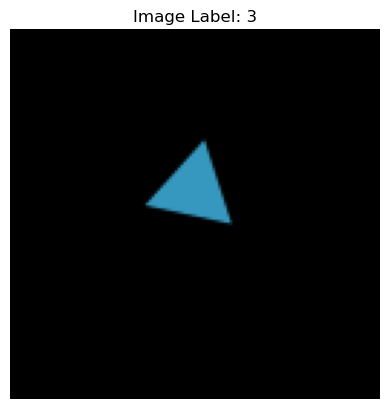

In [247]:
# Select an index
index_example = 999

# Get the item corresponding to the given index
[image_tensor,label] = training_dataset.__getitem__(index_example)

# Convert to NumPy format for plotting (0-1) -> (0-255)
image_np = F.to_pil_image(image_tensor)  # Convert back to PIL

# Plot the image
plt.imshow(image_np)
plt.axis("off")  # Hide axes
plt.title(f"Image Label: {label}") # Plot the size of the tensor
plt.show()

Choose the batch size and define the three dataloaders based on the batch size.

In [248]:
# Size of each batch
batch_size = 20 

# Define 3 DataLoaders: Training/Validation/Test 
training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=False)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# The Model

## Definition of the Convolutional Architecture

Definiton of the convolutional architecture for the classification based on shapes (number of vertices)

In [249]:
class ImageClassifier(nn.Module):
    def __init__(self, num_classes=7):
        '''
        latent_space_size : (int) number of dimensions of the latent space
        '''
        
        super(ImageClassifier, self).__init__()

        # Classifier
        self.classifier = nn.Sequential(
            # Convolutional layer with stride > 1 to downsample the image
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),            # (3, 128, 128) → (16, 64, 64) - Downsample
            nn.ReLU(),
            
            # Convolutional layer with stride > 1 to downsample the image
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),           # (16, 64, 64) → (32, 32, 32) - Downsample
            nn.ReLU(),

            # Convolutional layer with stride > 1 to downsample the image
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),           # (32, 32, 32) → (64, 16, 16) - Downsample
            nn.ReLU(),

            # Convolutional layer with stride > 1 to downsample the image
            nn.Conv2d(64, 32, kernel_size=3, stride=2, padding=1),          # (64, 16, 16) → (32, 8, 8) - Downsample
            nn.ReLU(),

            # Flatten layer to obtain R^(32*8*8) vector with dropout to improve training
            nn.Flatten(),
            nn.Dropout(0.2),

            # Linear layer 
            nn.Linear(32 * 8 * 8, num_classes)  
        )

    
    # Forward method
    def forward(self, x):
        
        # Classifier
        output = self.classifier(x)  
      
        return output



# Initialize the model and move it to the device
model = ImageClassifier().to(device)

x = torch.randn(1, 3, 128, 128).to(device)  # Batch size 1, 3 channel, 128x128 image
output = model(x)

print("Output shape:", output.shape)


Output shape: torch.Size([1, 7])


## Definition of the Loss 

Definition of the loss function: Cross Entropy for a classification task

In [250]:
# Loss function (Cross entropy loss):
loss_fn = nn.CrossEntropyLoss() 

Definition of learning rate and optimizer

In [251]:
# Optimizer (Adam): 
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Training phase

Training of the Classificator. The very high number of images in the training set makes it possible for convergence to be achieved in just a few epochs.

In [252]:
# Number of training epochs:
n_epochs = 10

training_loss_list = []
validation_loss_list = []

# Iterate over the epochs:
for epoch in range(n_epochs):

    # Set the model to Training mode: This interacts with certain kind of network layers (such as Dropout layers)
    model.train()  

    # Temporary variable to store the loss on the whole epoch as a convergence metric
    running_loss = 0.0

    # Iterate on the whole dataset using the dataloader.
    for nada_input, label_gt in training_dataloader:
        
        # Load inputs ad move to device (GPU)
        nada_input, label_gt = nada_input.to(device), label_gt.to(device)

        # Clear previous gradients
        optimizer.zero_grad()  
        
        # Forward pass (model calls)
        nada_model = model(nada_input)  

        # Compute loss (supervised case)
        loss = loss_fn(nada_model, label_gt)  
        
        # Backpropagation 
        loss.backward()  

        # Update parameters (optimization step)
        optimizer.step()  

        # Update running loss as convergence metric
        running_loss += loss.item()
        

    
    ## Calculate loss on validation as an additional metric to evaluate overfitting
    # Set the model to Evaluation mode:
    model.eval()

    # Temporary variable to store the validation loss:
    running_val_loss = 0.0
    
    # Deactivate gradient computation
    with torch.no_grad():
        for nada_input, label_gt in validation_dataloader:
            # Load inputs ad move to device (GPU)
            nada_input, label_gt = nada_input.to(device), label_gt.to(device)

            # Forward pass (model calls)
            nada_model = model(nada_input)

            # Compute loss (supervised case)
            loss = loss_fn(nada_model, label_gt)

            # Update validation running loss as convergence metric
            running_val_loss += loss.item()
            
    # Average epoch loss
    epoch_training_loss = running_loss / len(training_dataloader)
    epoch_validation_loss = running_val_loss / len(validation_dataloader)

    # Append the losses to the list:
    training_loss_list.append(epoch_training_loss)
    validation_loss_list.append(epoch_validation_loss)
            

    # Convergence metric
    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_training_loss:.4f}, Val. Loss: {epoch_validation_loss:.4f}")

Epoch [1/10], Loss: 1.2438, Val. Loss: 1.1466
Epoch [2/10], Loss: 1.1052, Val. Loss: 1.0559
Epoch [3/10], Loss: 0.8160, Val. Loss: 0.4052
Epoch [4/10], Loss: 0.3005, Val. Loss: 0.1617
Epoch [5/10], Loss: 0.1330, Val. Loss: 0.0287
Epoch [6/10], Loss: 0.0600, Val. Loss: 0.0146
Epoch [7/10], Loss: 0.0436, Val. Loss: 0.0550
Epoch [8/10], Loss: 0.0371, Val. Loss: 0.0309
Epoch [9/10], Loss: 0.0208, Val. Loss: 0.0098
Epoch [10/10], Loss: 0.0298, Val. Loss: 0.0316


# Results

## Convergence of the Model

Plot of the Training Loss and of the Validation Loss. 
The fact that they converge together and settle on the same value means that the model has not overfitted.


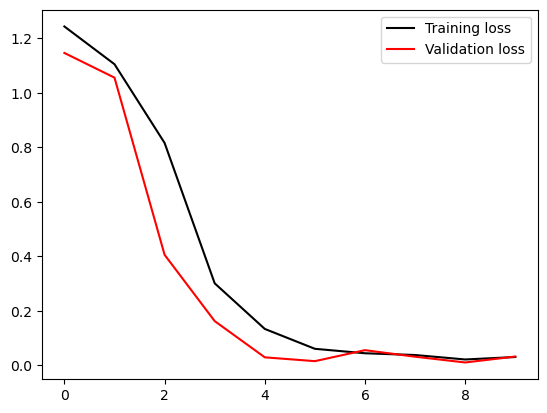

In [254]:
fig, ax = plt.subplots()

ax.plot(list(range(len(training_loss_list))), training_loss_list, color = 'black', label='Training loss')
ax.plot(list(range(len(validation_loss_list))), validation_loss_list,  color = 'red', label='Validation loss')
ax.legend()

## Performances on the Test Set

Evaluation of the trained model's behavior on the Test Set

In [255]:
# Use the model in evaluation mode:
model.eval()

# Define a list of predictions:
list_of_outputs = []
list_of_tensor_gt = []
list_label_prediction = []
list_gt = []

num_classes = 7

# Iterates without computing gradients:
with torch.no_grad():
    # Make a prediction for each training/validation/test inputs:
    for nada_input, label_gt in test_dataloader:
        
        # Forward pass (model calls)
        nada_model = model(nada_input)
        
        # Append the predictions on each class:
        list_of_outputs.append(nada_model[0])
        
        # Create the list of tensor-ground truth:
        gt_class = torch.zeros(num_classes)
        for j in range (num_classes):
            if j == label_gt:
                gt_class[j] = 1
        list_of_tensor_gt.append(gt_class)
        
        # Select the highest value among possible classes
        predicted_class = torch.argmax(nada_model)
        #print(predicted_class,label_gt)

        # Append the prediction to the list:
        list_label_prediction.append(int(predicted_class.to('cpu')))
        
        # Append the gt to the list:
        list_gt.append(int(label_gt.to('cpu')))

Evaluation of the model's performance on the Test Set through some metrics:
- Accuracy: fraction of correctly classified cases over total predictions
- Precision: fraction of correctly classified cases as belonging to a specific class over all instances predicted to belong to that class 
- Calibration Error: difference between the distributions of the model's predictions and the ground truth

In [256]:
import torchmetrics
# initialize metric
metric = torchmetrics.classification.Accuracy(task="multiclass", num_classes=7)

# move the metric to device you want computations to take place
device = "cuda" if torch.cuda.is_available() else "cpu"
metric.to(device)

preds = torch.tensor(list_label_prediction, dtype=torch.long)
target = torch.tensor(list_gt, dtype=torch.long)

acc = metric(preds, target)

print(f"Accuracy: {acc}")

Accuracy: 0.9980000257492065


In [257]:
preds = torch.stack(list_of_outputs, dim=0)
target = torch.tensor(list_gt, dtype=torch.long)

metric = torchmetrics.classification.MulticlassCalibrationError(num_classes=7, n_bins=3, norm='l1')
err = metric(preds, target)

print(f"Calibration error: {err}")

Calibration error: 0.017832262441515923


The Precision over the classes is calculated only for the geometric shapes present in the dataset: circles (0 vertices), triangles (3 verices), squares (4 vertices) and exagons (6 vertices). For example, figures with 1, 2 and 5 vertices are not present in the dataset, so precision can't be evaluated.

In [258]:
preds = torch.stack(list_of_outputs, dim=0)
target = torch.tensor(list_gt, dtype=torch.long)

metric = torchmetrics.classification.AveragePrecision(task="multiclass", num_classes=7, average=None)
prec = metric(preds, target)

print(f"Precision: {prec}")

Precision: tensor([1.0000,    nan,    nan, 1.0000, 1.0000,    nan, 0.9999])


Random sampling of an image from the Test Set and prediction of the class 

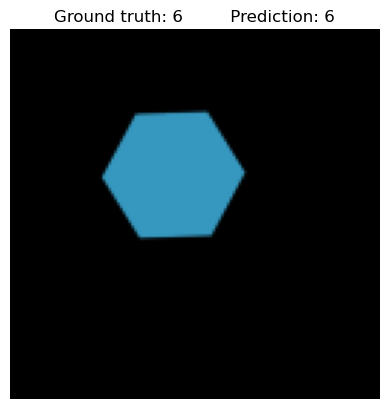

In [259]:
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# Select an index
nada_input, label_gt = next(iter(test_dataloader))   

# evaluation (model calls)
nada_model = model(nada_input)
        
# predictions on each class:
list_of_outputs.append(nada_model[0])
        
# Select the highest value among possible classes
predicted_class = torch.argmax(nada_model)

# Convert to NumPy format for plotting (0-1) -> (0-255)
image_np = F.to_pil_image(nada_input[0])  # Convert back to PIL

# Plot the image
plt.imshow(image_np)
plt.axis("off")  # Hide axes
plt.title(f"Ground truth: {label_gt[0]}         Prediction: {predicted_class}") # Plot the size of the tensor
plt.show()